# Modelling and Evaluation

## Objectives

Answer business requirement # 2:
* Predict if a cherry leaf is infected with powdery mildew or if it is healthy

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/test
* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* Image shape embeddings

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set working directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detection-in-cherry-leaves'

---

## Set input directories


* Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set label names

In [7]:
labels = os.listdir(train_path)
print(
    f"Image labels: {labels}"
    )

Image labels: ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




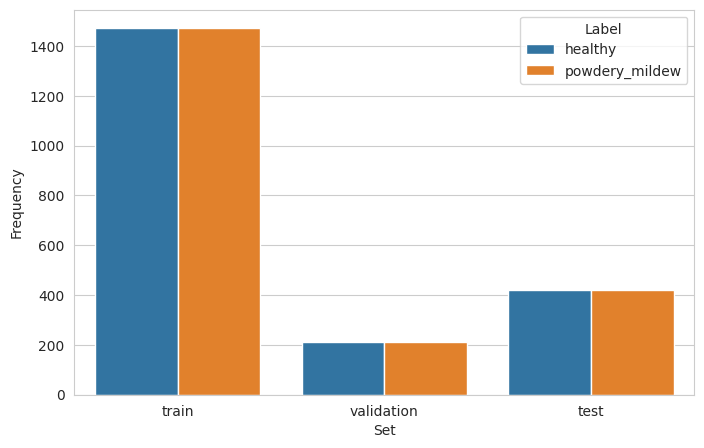

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

* Import ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* Initialize ImageDataGenerator

In [11]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

* Set batch size and augment training image dataset

In [12]:
batch_size = 16
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* Augment validation image dataset

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='categorical',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* Augment test image dataset

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented images

* Augmented training image

(16, 256, 256, 3)


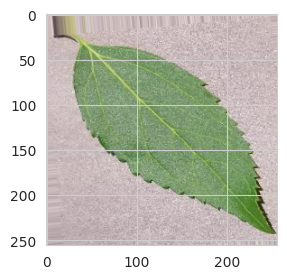

(16, 256, 256, 3)


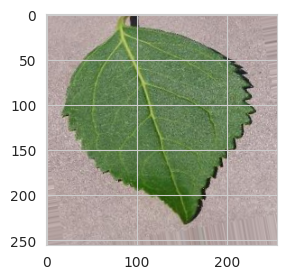

(16, 256, 256, 3)


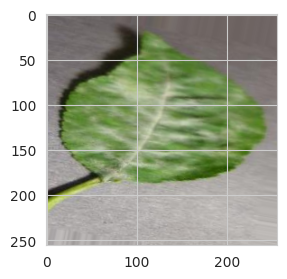

In [15]:
for _ in range(3):
    plt.figure(figsize=(3, 3))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

* Augmented validation image

(16, 256, 256, 3)


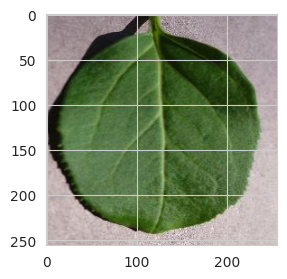

(16, 256, 256, 3)


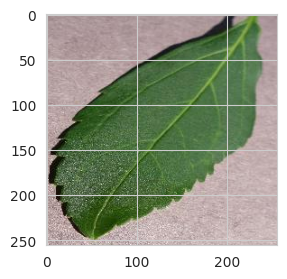

(16, 256, 256, 3)


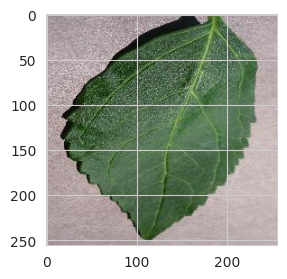

In [16]:
for _ in range(3):
    plt.figure(figsize=(3, 3))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

* Augmented test image

(16, 256, 256, 3)


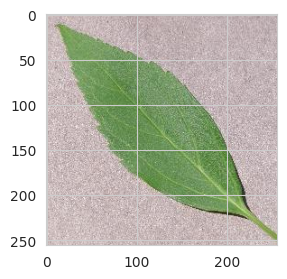

(16, 256, 256, 3)


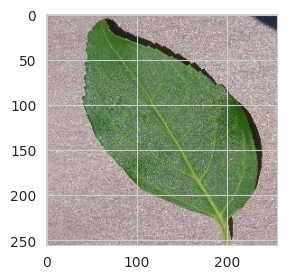

(16, 256, 256, 3)


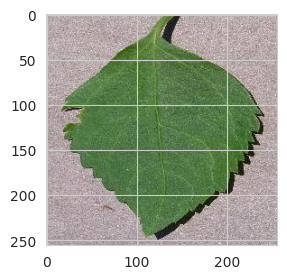

In [17]:
for _ in range(3):
    plt.figure(figsize=(3, 3))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model Creation

---

* Import model packages

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* Model

In [20]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))      
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))

    model.add(Dense(2, activation='softmax')) 

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adagrad',
                  metrics=['accuracy'])

    return model

* Model Summary

In [21]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2024-04-11 20:34:54.095027: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* Early Stopping

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit model for training

In [24]:
model = create_tf_model()
model.fit(train_set,
          epochs=20,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-04-11 20:39:53.985330: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
184/184 [==============================] - 114s 612ms/step - loss: 0.6338 - accuracy: 0.6613 - val_loss: 0.4876 - val_accuracy: 0.8167
Epoch 2/20
184/184 [==============================] - 110s 596ms/step - loss: 0.3972 - accuracy: 0.8322 - val_loss: 0.2854 - val_accuracy: 0.8905
Epoch 3/20
184/184 [==============================] - 101s 549ms/step - loss: 0.3113 - accuracy: 0.8675 - val_loss: 0.2790 - val_accuracy: 0.8667
Epoch 4/20
184/184 [==============================] - 97s 525ms/step - loss: 0.2814 - accuracy: 0.8811 - val_loss: 0.2888 - val_accuracy: 0.8476
Epoch 5/20
184/184 [==============================] - 103s 561ms/step - loss: 0.2451 - accuracy: 0.8978 - val_loss: 0.1923 - val_accuracy: 0.9357
Epoch 6/20
184/184 [==============================] - 100s 543ms/step - loss: 0.2305 - accuracy: 0.9035 - val_loss: 0.2206 - val_accuracy: 0.9286
Epoch 7/20
184/184 [==============================] - 101s 547ms/step - loss: 0.1974 - accuracy: 0.9256 - val_loss: 0.1486 - 

* Save model

In [26]:
model.save('outputs/v1/powdery_mildew_infection_model.h5')

---

## Model Performance

---

* Model Learning Curve

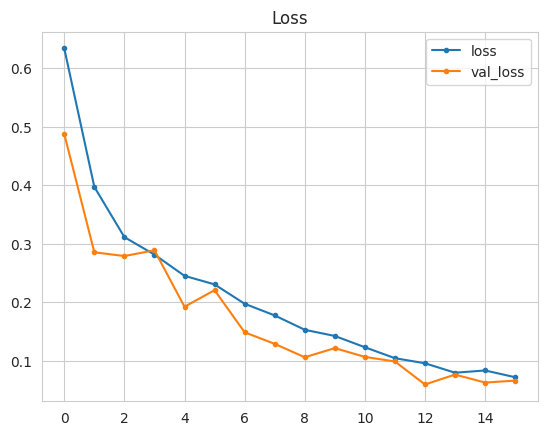

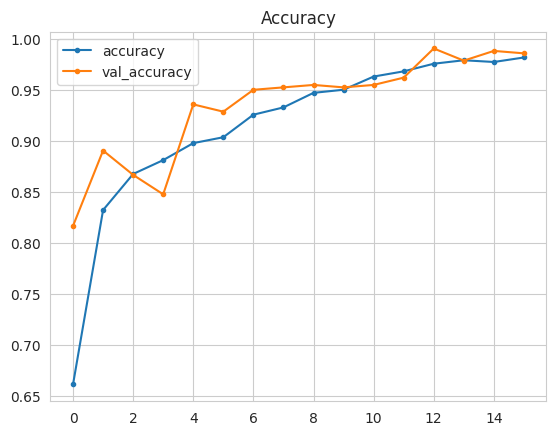

In [27]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model evaluation

* Load saved model

In [28]:
from keras.models import load_model
model = load_model('outputs/v1/powdery_mildew_infection_model.h5')

* Evaluate saved model
    * The accuracy level agreed with the client was 97%
    * The performance of the test set for this model is 98.1% therefore exceeding the clients agreed level

In [30]:
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))

 1/53 [..............................] - ETA: 10s - loss: 0.0064 - accuracy: 1.0000

53/53 [==============================] - 9s 160ms/step - loss: 0.0646 - accuracy: 0.9810
Model accuracy: 98.10%


* Save evaluation pickle

In [31]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

---

## Predict on new data

* Load random image as PIL

Image shape: (256, 256), Image mode: RGB


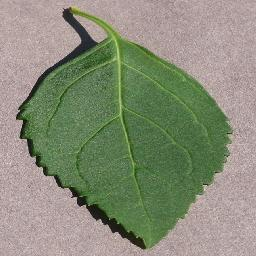

In [33]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select 0 for 'healthy' or 1 for 'powdery_mildew'

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

* Convert image to array and prepare for prediction

In [34]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


* Predict class probabilities

In [35]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.99426866
powdery_mildew


# Push files to Repo

* .gitignore

In [37]:
!cat .gitignore


core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json
inputs/cherry_leaves_dataset/cherry-leaves/test
inputs/cherry_leaves_dataset/cherry-leaves/train

* Git status

In [38]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .gitignore
	modified:   jupyter_notebooks/ModellingAndEvaluating.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


* Git add

In [39]:
!git add .

* Git commit

In [ ]:
!git commit -am "Predict on new data - ModellingAndEvaluating"

* Git push